In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from data_processing import make_classification, fetch_covtype, create_dataset
from MLP import MLP
from rainbow_MLP import rainbow_MLP
from testing import test
from torch.utils.data import DataLoader
from tqdm import tqdm
from training import train
from utils import check_normalisation, plot_results_2D, check_alignement

## Génération des données

In [84]:
X, y = make_classification(n_samples=5000, n_features=50, n_redundant=0, n_informative=50, n_classes=10)
#X, y = fetch_covtype()

train_data, val_data, test_data = create_dataset(X, y, normalize = True, prop_val = 0.7, prop_test = 0.15)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Performances d'échantillonnage en fonction du nombre d'époques

True
[INFO] training using cuda:1.
Largeur :  50 .
Largeur :  100 .
Largeur :  200 .
Largeur :  400 .


<Axes: xlabel="Nombre d'époques", ylabel='ROC AUC'>

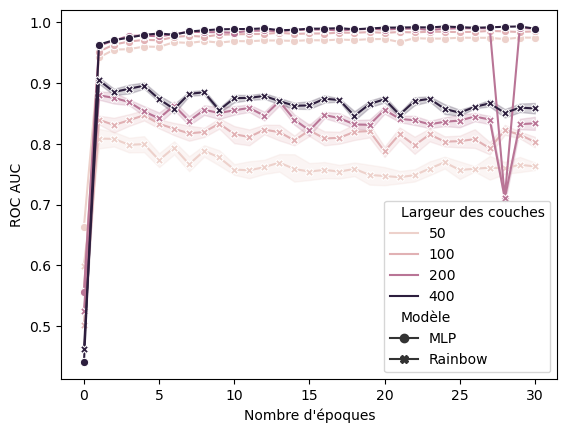

In [68]:
print(torch.cuda.is_available())
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}.".format(DEVICE))

nb_epochs = 30
step = 1

results_epochs = pd.DataFrame(columns=['ROC AUC', "Nombre d'époques", "Largeur des couches", 'Modèle', 'Run'])

for largeur in [50, 100, 200, 400]:
    hidden_layer_sizes = [largeur, largeur, np.max(train_data.tensors[1].numpy())+1]

    target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)

    target_model.to(DEVICE)
    
    print("Largeur : ", largeur, ".")
    
    for epoch in range(0, nb_epochs+step, step):

        ## Evaluation du MLP cible
        MLP_auc = test(target_model, test_dataloader, len(test_data), DEVICE, text = False)
        results_epochs = pd.concat([results_epochs, pd.DataFrame([[MLP_auc, epoch, largeur, 'MLP', 1]],
                                    columns=results_epochs.columns)], ignore_index=True)

        ## Ré-échantillonnage
        target_model.to("cpu")
        rainbow_model = rainbow_MLP(train_data.tensors[0].numpy().shape[1], hidden_layer_sizes, batch_norm = True)
        rainbow_model.approx(target_model)
        for run in range(10):
            _ = rainbow_model.resample(train_data[:][0].detach().numpy(), target_model, plot_alignement = -1)
            Rainbow_auc = test(rainbow_model, test_dataloader, len(test_data), 'cpu', text = False)

            results_epochs = pd.concat([results_epochs, pd.DataFrame([[Rainbow_auc, epoch, largeur, 'Rainbow', run]],
                                        columns=results_epochs.columns)], ignore_index=True)
        target_model.to(DEVICE)
        ## Entraînement sur 'step' époques du MLP cible
        if epoch < nb_epochs:
            train(target_model, train_dataloader, val_dataloader, step, len(train_data), DEVICE, text = False, plot = False)

sns.lineplot(data=results_epochs, x="Nombre d'époques", y="ROC AUC", hue="Largeur des couches",
             style="Modèle", markers=True, dashes=False)

## Performances d'échantillonnage en fonction de largeur des couches

Largeur :  52 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  78 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  117 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  175 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  263 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  395 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  592 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  888 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  1333 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .
Largeur :  2000 .
Nb d'époques :  3 .
Nb d'époques :  9 .
Nb d'époques :  27 .
Nb d'époques :  81 .


<Axes: xlabel='Largeur des couches', ylabel='ROC AUC'>

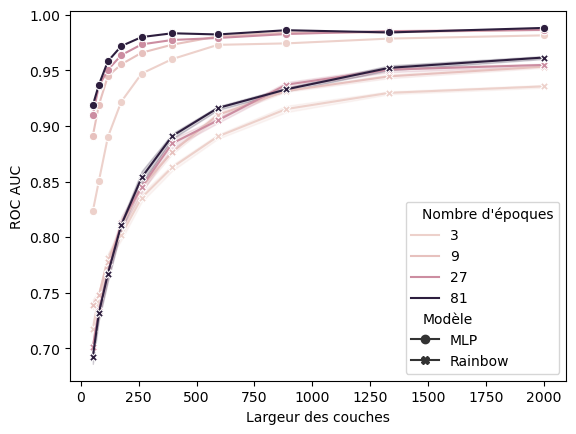

In [63]:
largeur_limite = 2000
largeurs = [int(2000/1.5**i) for i in range(9, -1, -1)]
nb_epochs = [int(3**i) for i in range(1, 5)] #[i for i in range(1, 11, 2)]

results_largeur = pd.DataFrame(columns=['ROC AUC', 'Largeur des couches', "Nombre d'époques", 'Modèle', 'Run'])

for largeur in largeurs:
    print('Largeur : ', largeur, '.')
    hidden_layer_sizes = [largeur, largeur, np.max(train_data.tensors[1].numpy())+1]
    for nb_epoch in nb_epochs:
        print("Nb d'époques : ", nb_epoch, '.')
        
        ## Entraînement du MLP cible
        target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
        target_model.to(DEVICE)
        train(target_model, train_dataloader, val_dataloader, nb_epoch, len(train_data), DEVICE, text = False, plot = False)
        MLP_auc = test(target_model, test_dataloader, len(test_data), DEVICE, text = False)
        results_largeur = pd.concat([results_largeur, pd.DataFrame([[MLP_auc, largeur, nb_epoch, 'MLP', 1]],
                                    columns=results_largeur.columns)], ignore_index=True)
        target_model.to('cpu')
        
        ## Ré-échantillonnage du modèle avec covariance
        rainbow_model = rainbow_MLP(train_data.tensors[0].numpy().shape[1], hidden_layer_sizes, batch_norm = True)
        rainbow_model.approx(target_model)
        for run in range(10):
            _ = rainbow_model.resample(train_data[:][0].detach().numpy(), target_model, plot_alignement = -1)
            Rainbow_auc = test(rainbow_model, test_dataloader, len(test_data), 'cpu', text = False)

            results_largeur = pd.concat([results_largeur, pd.DataFrame([[Rainbow_auc, largeur, nb_epoch, 'Rainbow', run]],
                                        columns=results_largeur.columns)], ignore_index=True)
    
sns.lineplot(data=results_largeur, x="Largeur des couches", y="ROC AUC", hue="Nombre d'époques",
             style="Modèle", markers=True, dashes=False)

## Comparaison avec le modèle "blanc"

Largeur :  62 .
Largeur :  125 .
Largeur :  250 .
Largeur :  500 .
Largeur :  1000 .


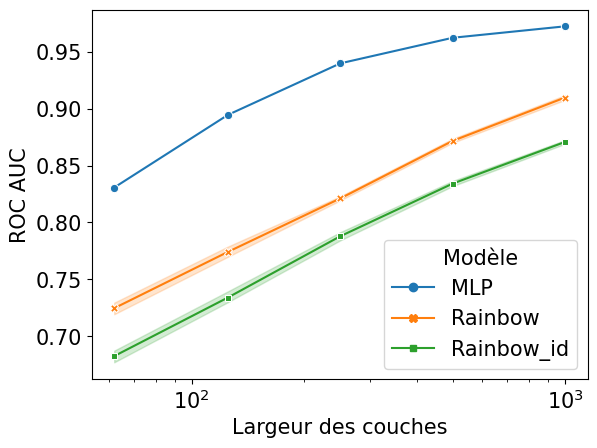

In [85]:
largeur_limite = 2000
nb_epochs = 3

results_largeur = pd.DataFrame(columns=['ROC AUC', 'Largeur des couches', 'Modèle', 'Run'])

for i in range(5,0,-1):
    largeur = int(largeur_limite/2**i)
    print('Largeur : ', largeur, '.')
    
    hidden_layer_sizes = [largeur, largeur, np.max(train_data.tensors[1].numpy())+1]
    
    ## Entraînement du MLP cible
    target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
    target_model.to(DEVICE)
    train(target_model, train_dataloader, val_dataloader, nb_epochs, len(train_data), DEVICE, text = False, plot = False)
    MLP_auc = test(target_model, test_dataloader, len(test_data), DEVICE, text = False)
    results_largeur = pd.concat([results_largeur, pd.DataFrame([[MLP_auc, largeur, 'MLP', 1]],
                                columns=results_largeur.columns)], ignore_index=True)
    target_model.to('cpu')
    
    ## Ré-échantillonnage du modèle avec covariance
    rainbow_model = rainbow_MLP(train_data.tensors[0].numpy().shape[1], hidden_layer_sizes, batch_norm = True)
    rainbow_model.approx(target_model)
    for run in range(10):
        _ = rainbow_model.resample(train_data[:][0].detach().numpy(), target_model, plot_alignement = -1)
        Rainbow_auc = test(rainbow_model, test_dataloader, len(test_data), 'cpu', text = False)

        results_largeur = pd.concat([results_largeur, pd.DataFrame([[Rainbow_auc, largeur, 'Rainbow', run]],
                                    columns=results_largeur.columns)], ignore_index=True)
        
    ## Ré-échantillonnage du modèle avec covariance identité
    rainbow_model_id = rainbow_MLP(train_data.tensors[0].numpy().shape[1], hidden_layer_sizes, batch_norm = True)
    rainbow_model_id.approx(target_model)
    rainbow_model_id.C_identity()
    for run in range(10):
        _ = rainbow_model_id.resample(train_data[:][0].detach().numpy(), target_model, plot_alignement = -1)
        Rainbow_auc = test(rainbow_model_id, test_dataloader, len(test_data), 'cpu', text = False)

        results_largeur = pd.concat([results_largeur, pd.DataFrame([[Rainbow_auc, largeur, 'Rainbow_id', run]],
                                    columns=results_largeur.columns)], ignore_index=True)
    

sns.lineplot(data=results_largeur, x="Largeur des couches", y="ROC AUC", hue="Modèle",
             style="Modèle", markers=True, dashes=False)
plt.xscale('log')
plt.show()
#plt.savefig('fig/id_cov.pdf')

## Diagramme de phases

100%|███████████████████████████████████████████| 35/35 [19:01<00:00, 32.60s/it]


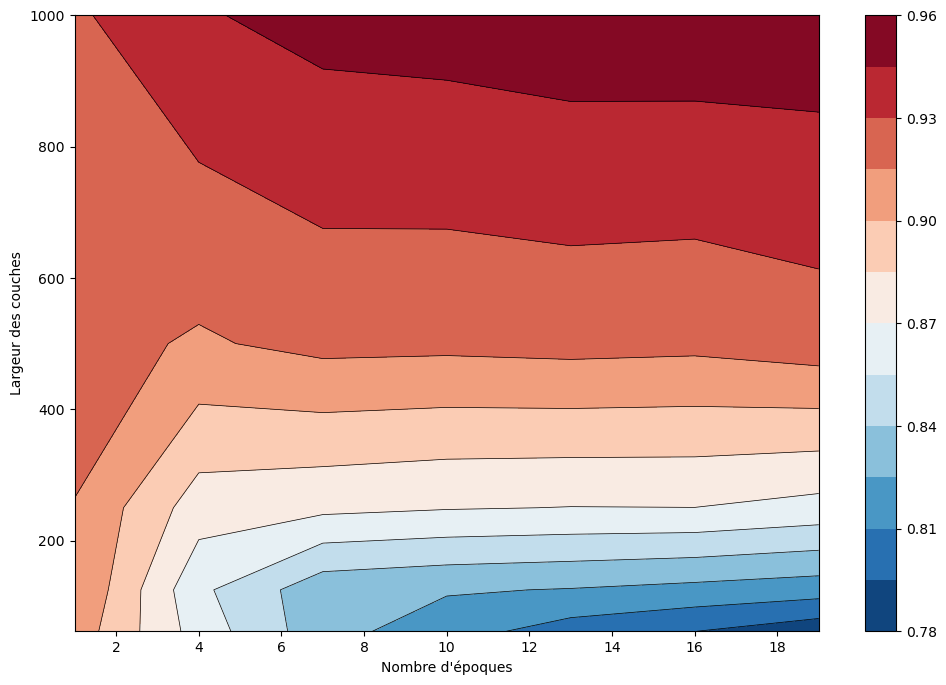

In [52]:
def compute_ratio(nb_epoch, largeur, nb_runs):
    
    hidden_layer_sizes = [largeur, largeur, np.max(train_data.tensors[1].numpy())+1]
    ratio = []
    
    for run in range(nb_runs):
        ## Entraînement du MLP cible
        target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
        target_model.to(DEVICE)
        train(target_model, train_dataloader, val_dataloader, nb_epoch, len(train_data), DEVICE, text = False, plot = False)
        MLP_auc = test(target_model, test_dataloader, len(test_data), DEVICE, text = False)
        target_model.to('cpu')

        ## Ré-échantillonnage du modèle avec covariance

        rainbow_model = rainbow_MLP(train_data.tensors[0].numpy().shape[1], hidden_layer_sizes, batch_norm = True)
        rainbow_model.approx(target_model)
        _ = rainbow_model.resample(train_data[:][0].detach().numpy(), target_model, plot_alignement = -1)
        Rainbow_auc = test(rainbow_model, test_dataloader, len(test_data), 'cpu', text = False)
        
        ratio.append(Rainbow_auc/MLP_auc)

    return np.mean(ratio), np.var(ratio)
            


nb_runs = 10

fig, ax = plt.subplots(ncols=1, figsize=[12, 8])

colors = ['dodgerblue', 'crimson']
xx, yy = np.meshgrid(np.arange(1,20, 3), np.array([int(2000/2**i) for i in range(5,0,-1)]))
auc_ratio = []
for config in tqdm(np.c_[(xx.ravel(), yy.ravel())]):
    auc_ratio.append(compute_ratio(int(config[0]), int(config[1]), nb_runs)[0])
auc_ratio = np.array(auc_ratio)
ax.contour(xx, yy, auc_ratio.reshape(xx.shape), levels=14, linewidths=0.5, colors='k')
cntr = ax.contourf(xx, yy, auc_ratio.reshape(xx.shape), levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

plt.xlabel("Nombre d'époques")
plt.ylabel('Largeur des couches')

plt.show()